In [1]:
import numpy as np
import nnfs
from nnfs.datasets import spiral_data

In [2]:
nnfs.init()

In [4]:
# Dense layer
class Layer_Dense:
    # Layer initialization
    def __init__(self, n_inputs, n_neurons):
        # Initialize weights and biases
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
    # Forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs
        # Calculate output values from inputs, weights and biases
        self.output = np.dot(inputs, self.weights) + self.biases
        # Backward pass
    def backward(self, dvalues):
        # Gradients on parameters
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        # Gradient on values
        self.dinputs = np.dot(dvalues, self.weights.T)

In [5]:
# ReLU activation
class Activation_ReLU:
    # Forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs
        # Calculate output values from inputs
        self.output = np.maximum(0, inputs)
    # Backward pass
    def backward(self, dvalues):
        # Since we need to modify original variable,
        # let's make a copy of values first
        self.dinputs = dvalues.copy()
        # Zero gradient where input values were negative
        self.dinputs[self.inputs <= 0] = 0

In [7]:
# Softmax activation
class Activation_Softmax:
    # Forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs
        # Get unnormalized probabilities
        exp_values = np.exp(inputs - np.max(inputs, axis=1,
        keepdims=True))
        # Normalize them for each sample
        probabilities = exp_values / np.sum(exp_values, axis=1,
        keepdims=True)
        self.output = probabilities
    # Backward pass
    def backward(self, dvalues):
        # Create uninitialized array
        self.dinputs = np.empty_like(dvalues)
        # Enumerate outputs and gradients
        for index, (single_output, single_dvalues) in \
        enumerate(zip(self.output, dvalues)):
        # Flatten output array
            single_output = single_output.reshape(-1, 1)
            # Calculate Jacobian matrix of the output and
            jacobian_matrix = np.diagflat(single_output) - \
                np.dot(single_output, single_output.T)
            # Calculate sample-wise gradient
            # and add it to the array of sample gradients
            self.dinputs[index] = np.dot(jacobian_matrix,
            single_dvalues)

In [8]:
# Common loss class
class Loss:
    # Calculates the data and regularization losses
    # given model output and ground truth values
    def calculate(self, output, y):
        # Calculate sample losses
        sample_losses = self.forward(output, y)
        # Calculate mean loss
        data_loss = np.mean(sample_losses)
        # Return loss
        return data_loss


In [11]:
# Cross-entropy loss
class Loss_CategoricalCrossentropy(Loss):
    # Forward pass
    def forward(self, y_pred, y_true):
        # Number of samples in a batch
        samples = len(y_pred)
        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
        # Probabilities for target values -
        # only if categorical labels
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[
            range(samples),
            y_true
            ]
        
        # Mask values - only for one-hot encoded labels
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(
            y_pred_clipped * y_true,
            axis=1
            )
        # Losses
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods
    # Backward pass
    def backward(self, dvalues, y_true):
        # Number of samples
        samples = len(dvalues)
        # Number of labels in every sample
        # We'll use the first sample to count them
        labels = len(dvalues[0])
        # If labels are sparse, turn them into one-hot vector
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]
        # Calculate gradient
        self.dinputs = -y_true / dvalues
        # Normalize gradient
        self.dinputs = self.dinputs / samples

In [32]:
# Softmax classifier - combined Softmax activation
# and cross-entropy loss for faster backward step
class Activation_Softmax_Loss_CategoricalCrossentropy():
   # Creates activation and loss function objects
    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossentropy()
    # Forward pass
    def forward(self, inputs, y_true):
        # Output layer's activation function
        self.activation.forward(inputs)
        # Set the output
        self.output = self.activation.output
        # Calculate and return loss value
        return self.loss.calculate(self.output, y_true)

    # The 'y_true' argument MUST be present in the method signature
    def backward(self, dvalues, y_true):
        # Samples
        samples = len(dvalues)
        
        # Now 'y_true' is accessible
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)

        # Copy so we can safely modify
        self.dinputs = dvalues.copy()
        # Calculate gradient
        self.dinputs[range(samples), y_true] -= 1
        # Normalize gradient
        self.dinputs = self.dinputs / samples

In [33]:
# Create dataset
X, y = spiral_data(samples=100, classes=3)

In [34]:
import matplotlib.pyplot as plt 

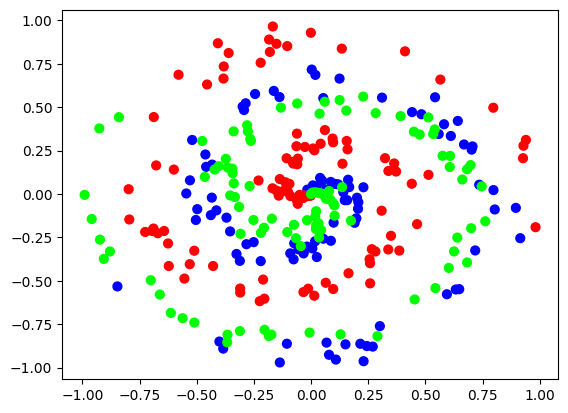

In [35]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='brg', s=40)

In [36]:
# Create Dense layer with 2 input features and 3 output values
dense1 = Layer_Dense(2, 3)

In [37]:
# Create ReLU activation (to be used with Dense layer):
activation1 = Activation_ReLU()

In [38]:
# Create second Dense layer with 3 input features (as we take output
# of previous layer here) and 3 output values (output values)
dense2 = Layer_Dense(3, 3)

In [39]:
# Create Softmax classifier's combined loss and activation
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

In [40]:
# Perform a forward pass of our training data through this layer
dense1.forward(X)

In [41]:
# Perform a forward pass through activation function
# takes the output of first dense layer here
activation1.forward(dense1.output)

In [42]:
# Perform a forward pass through second Dense layer
# takes outputs of activation function of first layer as inputs
dense2.forward(activation1.output)

In [43]:
# Perform a forward pass through the activation/loss function
# takes the output of second dense layer here and returns loss
loss = loss_activation.forward(dense2.output, y)

In [44]:
loss

np.float32(1.0986109)

In [45]:
# Calculate accuracy from output of activation2 and targets
# calculate values along first axis
predictions = np.argmax(loss_activation.output, axis=1)
if len(y.shape) == 2:
     y = np.argmax(y, axis=1)
accuracy = np.mean(predictions==y)


In [46]:
accuracy

np.float64(0.29333333333333333)

In [47]:
# Backward pass
loss_activation.backward(loss_activation.output, y)
dense2.backward(loss_activation.dinputs)
activation1.backward(dense2.dinputs)
dense1.backward(activation1.dinputs)
# Print gradients
print(dense1.dweights)
print(dense1.dbiases)
print(dense2.dweights)
print(dense2.dbiases)

[[-8.7130407e-05 -3.1247226e-04  1.4807502e-04]
 [ 2.1532600e-04  1.3320666e-04 -2.5005499e-04]]
[[-1.2967290e-04  8.2296156e-04 -7.7169541e-05]]
[[-6.87162101e-05  1.13812661e-04 -4.50964653e-05]
 [ 8.57070190e-05 -7.94074222e-05 -6.29961005e-06]
 [ 2.55059076e-05 -1.26656974e-04  1.01151054e-04]]
[[ 4.2209867e-06 -3.6060810e-06 -5.0105155e-07]]
